# Melon data preprocessing & Training

### Yonsei App.Stat.
### Sunwoo Kim

------------

EASE 모델이 item x item의 역행렬을 계산해야하므로, 제공된 모든 데이터를 사용하는 것은 다소 제한적입니다.  
따라서 
- json file을 연산 가능한 형태로 변형.  
- playlist에 많이 등록된 노래만 샘플링하여, 일부 데이터로만 학습.  

의 작업을 수행할 예정입니다.

## 1. Converting to CSV

Read file

In [2]:
path = "C:\\Users\\kswoo\\OneDrive\\바탕 화면\\EASE\\"
with open(os.path.join(path, 'train.json'), 'rt',encoding='UTF8') as json_file:
    data = json.load(json_file)

Convert

In [ ]:
train_data = pd.DataFrame([])
train_tags = pd.DataFrame([])
for i in tqdm(range(115071)) : 
    the_length = len(data[i]['songs'])
    the_data = pd.DataFrame({'user_id' : np.repeat(data[i]['id'], the_length),
                         'music_id' : data[i]['songs'], 
                         'playlist_title' : np.repeat(data[i]['plylst_title'], the_length), 
                         'likes' : np.repeat(data[i]['like_cnt'], the_length), 
                         'update_dates' : np.repeat(data[i]['updt_date'], the_length)})
    the_data_2 = pd.DataFrame({'user_id' : [data[i]['id']], 
                               'tags' : [data[i]['tags']]})
    train_data = pd.concat([train_data, the_data], axis = 0)
    train_tags = pd.concat([train_tags, the_data_2])

## 2. Remove duplicated songs

다양한 플레이리스트에 동일한 노래가 들어간 경우가 많아, 데이터를 그대로 사용하면  
중복된 노래가 추천됩니다. 따라서 노래 제목 & 아티스트가 동일한 경우 모두 중복 데이터로  
처리하여 같은 음악 key로 맞춰줍니다.

In [ ]:
song_info = pd.read_csv('song_information.csv').iloc[:, 1:]
print(train_data.head(3))
song_info.head(3)

song_name = song_info.song_name.values # 노래명
artist_name = song_info.artist_name.values # 아티스트명
needed_key = song_info.groupby( # 필요한 키로 정렬
    by = ['song_name'], as_index = False).count()[
    song_info.groupby(by = ['song_name'], as_index = False).count().song_id  > 1].song_name.values

# 어떤 음악이 정렬의 대상인가?
interest_keys = song_info[song_info['song_name'].isin(needed_key)].song_id.values 

중복을 제거합니다. (시간 오래 걸림)

In [ ]:
same_songs = []
finished = []
to_be_deleted = []

for i in tqdm(interest_keys) : 
    
    if i in finished : 
        to_be_deleted.append(i)
    
    else : 
        song_ = song_name[i]
        artist_ = artist_name[i]
        comp_lists = np.where(song_name == song_)[0]
        same_with = [i]
        
        if comp_lists.shape[0] == 1 : 
            None 
            
        else : 
            keys_ = np.setdiff1d(np.where(song_name == song_)[0], [i])
            for new_index in keys_ : 

                if artist_ == artist_name[new_index] : 
                    same_with.append(new_index)
                    finished.append(new_index)
        
        same_songs.append(same_with)
        finished.append(i)

선정된 음악으로 최종적으로 새로운 데이터 생성

In [ ]:
musics = train_data.music_id.values
edit_musics = musics.copy()

In [ ]:
for dup in tqdm(same_songs) : 
    if len(dup) < 2 : None
    else : 
        for part in dup[1:] : 
            edit_musics[np.where(edit_musics == part)[0]] = dup[0]

In [ ]:
# new_train.csv에 이제 새로운 노래들이 할당된 상태
train_data['new_music_id'] = edit_musics
new_train = train_data.drop(['update_dates'], axis = 1)
new_train.to_csv('new_train.csv')

## 3. Music Sampling

현실적인 제약으로 인해 모든 데이터를 사용하는 것은 불가능.  
따라서 sampling을 시행하는데, 
- 플레이리스트에 3번 이상 수록된 곡 (너무 minor한 곡은 제외)
- 음악을 3개 이상 수록하고 있는 플레이리스트 (너무 수록곡이 적은 플레이리스트는 제외)

In [ ]:
new_train = pd.read_csv('new_train.csv').iloc[:, 1:]

일부 데이터만 추출하는 함수 정의

In [ ]:
def item_extractor(x, user_t, item_t) : 
    
    index_checking = x.groupby(by = ['new_music_id'], as_index = False).count()
    new_index = index_checking[index_checking.user_id >= item_t].new_music_id.values
    first = x[x['new_music_id'].isin(new_index)]
    
    index_checking2 = first.groupby(by = ['user_id'], as_index = False).count()
    new_2 = index_checking2[index_checking2.values >= user_t].user_id.values

    return first[first['user_id'].isin(new_2)]

In [ ]:
# final_x.csv라는 이름의 최종 학습에 사용할 데이터 생성
new_x = item_extractor(new_train, 3, 3)
new_x.to_csv('final_x.csv', index = False)

## 4. Training

Utility matrix **X**를 생성

In [ ]:
data = pd.read_csv('final_x.csv')

user_enc = LabelEncoder()
item_enc = LabelEncoder()

user_index = user_enc.fit_transform(data.user_id.values).astype(int)
item_index = item_enc.fit_transform(data.new_music_id.values).astype(int)

X = csr_matrix((np.ones(user_index.shape[0]).astype(int), (user_index, item_index)))

**G = $X^{T}X$**

In [ ]:
G = X.T.dot(X).toarray().astype(float)
diagIndices = np.diag_indices(G.shape[0])
G[diagIndices] += 0.5 # Lambda

**$\hat{P} = (X^{T}X + \lambda I)^{-1} $**  

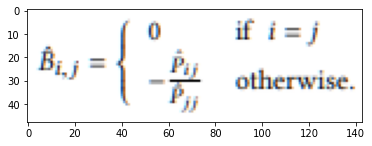

In [5]:
import cv2
import matplotlib.pyplot as plt
image = cv2.imread('beta.PNG')
plt.imshow(image)
plt.show()

In [ ]:
P = np.linalg.inv(G)
print('First Step Done!')
B = P / (-np.diag(P))
print('Second Step Done!')
B[diagIndices] = 0

아이템 유사도가 학습된 B matrix가 추정 완료됨.   
B matrix와 각 아이템 key를 저장함.

In [ ]:
np.save('B_mat', B)
np.save('user_classes.npy', user_enc.classes_)
np.save('item_classes.npy', item_enc.classes_)